In [1]:
#imoport some packages to use 

import os 
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow.keras
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from PIL import Image

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


Using TensorFlow backend.


In [2]:
inception_v3_model = InceptionV3(weights='imagenet', include_top=False)

x = inception_v3_model.output
x= GlobalAveragePooling2D()(x) #  GlobalAveragePooling2D 将 MxNxC 的张量转换成 1xC 张量，C是通道数
x = Dense(1024, activation='relu')(x)

#predictions = Dense(17, activation='softmax')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=inception_v3_model.input, outputs=predictions)
# plot_model(model, 't1mode.png')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [3]:
from keras.optimizers import Adam, RMSprop, SGD

def setup_to_fine_tune(model, base_model):
    GAP_LAYER=17

    for layer in base_model.layers[:GAP_LAYER+1]:
        layer.trainable = False

    for layer in base_model.layers[GAP_LAYER+1:]:
        layer.trainable = True

   # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    #adm =Adam(lr=0.0001) 
   # adam = Adam(lr=1e-6)
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    

In [4]:
def preprocess(imageRawDir):
    """
    images preprocess

    Arguments:
    imageRawDir -- directory of primary images.
    

    Return: preprocessed images and labels.
    """
    imageNames = os.listdir(imageRawDir)
    img=np.zeros(shape=(len(imageNames), 224 ,224,3))
    label=[]
    
    #label = read_and_process_images() # directory format："./data/cat/"
    for index, imageName in enumerate(imageNames):
        #print(imageName)
        image = Image.open(os.path.join(imageRawDir,imageName))
        image=np.array(image) 
        image=preprocess_input(image)
        img[index]=image
        label_1= imageName.split("_")[0]
        label_2 = label_1.split("ion")[1]
        if(label_2=='1'):
         #   print('switch')
            label_2='0'
        if(label_2=='2'):
         #   print('switch')
            label_2='0'
        if(label_2=='3'):
         #   print('switch')
            label_2='1'
        if(label_2=='4'):
         #   print('switch')
            label_2='1'
        label.append(label_2)
        #print(label)
       # label.append(imageName.split("_")[0])
        
      
    return img,label
     

In [5]:
def preprocess_unlabel(imageRawDir):
    """
    images preprocess

    Arguments:
    imageRawDir -- directory of primary images.
    

    Return: preprocessed images.
    """
    imageNames = os.listdir(imageRawDir)
    img=np.zeros(shape=(len(imageNames), 224 ,224,3))
   # label=[]
    
    #label = read_and_process_images() # directory format："./data/cat/"
    for index, imageName in enumerate(imageNames):
        #print(imageName)
        image = Image.open(os.path.join(imageRawDir,imageName))
        image=np.array(image) 
        image=preprocess_input(image)
        img[index]=image
        
        #print(label)
       # label.append(imageName.split("_")[0])
        
      
    return img
     

In [6]:
def encode_y(y):
    y=np.array(y)
    le = LabelEncoder()
    y = le.fit_transform(y)


    y=to_categorical(y)
    y=np.array(y)
    print(y.shape)
    return(y)
    

In [7]:
train_dir="condition_aug_train/"
train_img,train_y = preprocess(train_dir)
train_y=encode_y(train_y)



(12657, 2)


In [8]:
import gc
gc.collect()

0

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(train_img,train_y,test_size=0.20, random_state=42)
del(train_img,train_y)



In [10]:
from datetime import datetime
from tensorflow.keras import callbacks
start = datetime.now()
setup_to_fine_tune(model, inception_v3_model)
es_callback =tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, Y_train, epochs=20, batch_size=32,validation_data=(X_valid,Y_valid),callbacks=[es_callback])
end = datetime.now()
print('Traning the Fine Tune model:', (end - start))

Epoch 1/20
317/317 [==============================] - 43s 135ms/step - loss: 0.5634 - accuracy: 0.7061 - val_loss: 0.5212 - val_accuracy: 0.7405
Epoch 2/20
317/317 [==============================] - 40s 125ms/step - loss: 0.2760 - accuracy: 0.8900 - val_loss: 0.5092 - val_accuracy: 0.7982
Epoch 3/20
317/317 [==============================] - 39s 122ms/step - loss: 0.0897 - accuracy: 0.9725 - val_loss: 0.4539 - val_accuracy: 0.8314
Epoch 4/20
317/317 [==============================] - 39s 122ms/step - loss: 0.0504 - accuracy: 0.9823 - val_loss: 0.5031 - val_accuracy: 0.8456
Epoch 5/20
317/317 [==============================] - 38s 121ms/step - loss: 0.0458 - accuracy: 0.9852 - val_loss: 0.5261 - val_accuracy: 0.8468
Epoch 6/20
317/317 [==============================] - 38s 119ms/step - loss: 0.0411 - accuracy: 0.9858 - val_loss: 0.5665 - val_accuracy: 0.8468
Epoch 7/20
317/317 [==============================] - 38s 120ms/step - loss: 0.0377 - accuracy: 0.9867 - val_loss: 0.8909 - val_ac

In [11]:
es_callback =tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, Y_train, epochs=2, batch_size=32,validation_data=(X_valid,Y_valid),callbacks=[es_callback])
end = datetime.now()

Epoch 1/2
317/317 [==============================] - 40s 125ms/step - loss: 0.0121 - accuracy: 0.9955 - val_loss: 0.6363 - val_accuracy: 0.8744
Epoch 2/2
317/317 [==============================] - 38s 119ms/step - loss: 0.0145 - accuracy: 0.9954 - val_loss: 0.5737 - val_accuracy: 0.8740


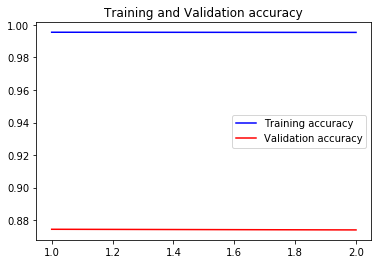

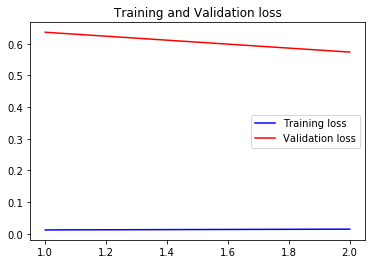

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs =  range(1,len(acc)+1)

#train and validation accuracy 
plt.plot(epochs, acc, 'b', label ='Training accuracy')
plt.plot(epochs, val_acc, 'r', label ='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()


plt.figure()


#Train and validation loss
plt.plot(epochs, loss, 'b', label ='Training loss')
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
#plt.title('Train

In [13]:
del(X_train, Y_train, X_valid, Y_valid)

In [14]:
test_dir = "condition_aug_test/"
test_img,test_y= preprocess(test_dir)
test_y = encode_y(test_y)

(3160, 2)


In [15]:
score = model.evaluate(test_img, test_y, verbose=1)
print(score)

99/99 [==============================] - 5s 46ms/step - loss: 0.5497 - accuracy: 0.8769
[0.5496561527252197, 0.8768987059593201]


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
pred_y = model.predict(test_img)
pred_class = np.argmax(pred_y, axis=1)
test_class= np.argmax(test_y, axis=1)
score = accuracy_score(test_class, pred_class)
print(score)
confusion_matrix(test_class,pred_class)

In [16]:
del(test_img, test_y)

# Unlabel

In [52]:
unlabel_dir ="unlabel_save/"
unlabel_img = preprocess_unlabel(unlabel_dir)

In [53]:
pseudo_labeles = model.predict(unlabel_img)
pseudo_labeles.shape
pseudo_idx = np.argmax(pseudo_labeles, axis=1)

In [54]:
import numpy as np
number_image = [0,0,0,0,0]
select_train_y  = []
select_train_img=[]
for i in range(0,len(pseudo_labeles)):
    pseudo_label = pseudo_idx[i]
    confidence = pseudo_labeles[i][pseudo_label]
    confidence_per_class = [0.95,0.95,0.95,0.95,0.95]
    if pseudo_labeles[i][pseudo_label]>=confidence_per_class[pseudo_label]:
        select_train_y.append(pseudo_label)
        select_train_img.append(unlabel_img[i])
        number_image[pseudo_label] +=1
print(number_image)


[2779, 5604, 0, 0, 0]


In [55]:
del(unlabel_img)

In [56]:
select_train_y = encode_y(select_train_y )
select_train_img = np.array(select_train_img)

(8383, 2)


In [57]:
train_dir="condition_aug_train/"
train_img,train_y = preprocess(train_dir)
train_y=encode_y(train_y)



(12657, 2)


In [58]:
result_img = np.concatenate((train_img, select_train_img))
result_y = np.concatenate((train_y, select_train_y))




In [59]:
del(train_img,train_y,select_train_img,select_train_y)

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(result_img,result_y,test_size=0.2, random_state=42)




In [61]:
del(result_img, result_y)

In [62]:
from datetime import datetime
from tensorflow.keras import callbacks
start = datetime.now()
setup_to_fine_tune(model, inception_v3_model)
es_callback =tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, Y_train, epochs=10, batch_size=32,validation_data=(X_valid,Y_valid),callbacks=[es_callback])
end = datetime.now()
print('Traning the Fine Tune model:', (end - start))

Epoch 1/10
526/526 [==============================] - 76s 145ms/step - loss: 0.0397 - accuracy: 0.9870 - val_loss: 0.0797 - val_accuracy: 0.9777
Epoch 2/10
526/526 [==============================] - 70s 133ms/step - loss: 0.0213 - accuracy: 0.9925 - val_loss: 0.0771 - val_accuracy: 0.9796
Epoch 3/10
526/526 [==============================] - 70s 134ms/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.1049 - val_accuracy: 0.9767
Epoch 4/10
526/526 [==============================] - 71s 135ms/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 0.0878 - val_accuracy: 0.9784
Epoch 5/10
526/526 [==============================] - 69s 131ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.0832 - val_accuracy: 0.9812
Epoch 6/10
526/526 [==============================] - 70s 133ms/step - loss: 0.0039 - accuracy: 0.9985 - val_loss: 0.0922 - val_accuracy: 0.9791
Epoch 7/10
526/526 [==============================] - 69s 132ms/step - loss: 0.0089 - accuracy: 0.9973 - val_loss: 0.0847 - val_ac

In [63]:
es_callback =tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, Y_train, epochs=10, batch_size=32,validation_data=(X_valid,Y_valid),callbacks=[es_callback])

Epoch 1/10
526/526 [==============================] - 74s 141ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.0894 - val_accuracy: 0.9791
Epoch 2/10
526/526 [==============================] - 71s 134ms/step - loss: 0.0049 - accuracy: 0.9982 - val_loss: 0.0942 - val_accuracy: 0.9760
Epoch 3/10
526/526 [==============================] - 72s 136ms/step - loss: 0.0063 - accuracy: 0.9980 - val_loss: 0.1102 - val_accuracy: 0.9769
Epoch 4/10
526/526 [==============================] - 70s 134ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.0984 - val_accuracy: 0.9784
Epoch 5/10
526/526 [==============================] - 72s 137ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.1019 - val_accuracy: 0.9791
Epoch 6/10
526/526 [==============================] - 71s 136ms/step - loss: 0.0042 - accuracy: 0.9985 - val_loss: 0.1113 - val_accuracy: 0.9798


In [64]:
del(X_train, Y_train, X_valid, Y_valid)

In [65]:
test_dir = "condition_aug_test/"
test_img,test_y= preprocess(test_dir)
test_y = encode_y(test_y)

(3160, 2)


In [66]:
score = model.evaluate(test_img, test_y, verbose=1)
print(score)

99/99 [==============================] - 5s 50ms/step - loss: 0.4941 - accuracy: 0.9171
[0.4940830171108246, 0.9170886278152466]


In [32]:
score = model.evaluate(test_img, test_y, verbose=1)
print(score)

99/99 [==============================] - 4s 43ms/step - loss: 0.4850 - accuracy: 0.9136
[0.4849604666233063, 0.9136075973510742]


In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
pred_y = model.predict(test_img)
pred_class = np.argmax(pred_y, axis=1)
test_class= np.argmax(test_y, axis=1)
score = accuracy_score(test_class, pred_class)
print(score)
confusion_matrix(test_class,pred_class)

0.9136075949367088


array([[1041,  142],
       [ 131, 1846]])

In [67]:
del(test_img, test_y)

# Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest',preprocessing_function=None)


val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow(X_train, Y_train,batch_size=32)
val_generator = val_datagen.flow(X_valid, Y_valid, batch_size=32)

In [ ]:
from datetime import datetime
from tensorflow.keras import callbacks
start = datetime.now()
nb_epoch = 60
from datetime import datetime
from tensorflow.keras import callbacks
import random
start = datetime.now()
nb_epoch = 60


setup_to_fine_tune(model, inception_v3_model)
# Start Fine-tuning

es_callback =tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
#history = model.fit(X_train, Y_train,batch_size=batch_size,epochs=nb_epoch,shuffle=True,verbose=1,validation_data=(X_valid, Y_valid),callbacks=[es_callback])

history = model.fit_generator(train_generator, 
                             steps_per_epoch=200, 
                              epochs=200,
                             validation_data=val_generator, 
                              validation_steps=50, 
                              callbacks=[es_callback],
                              shuffle=True,
                              verbose=1)

end = datetime.now()

In [ ]:
test_img = 1./255*test_img

In [ ]:
score = model.evaluate(test_img, test_y, verbose=1)
print(score)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
pred_y = model.predict(test_img)
pred_class = np.argmax(pred_y, axis=1)
test_class= np.argmax(test_y, axis=1)
score = accuracy_score(test_class, pred_class)
print(score)
confusion_matrix(test_class,pred_class)